In [1]:
import numpy as np
import cv2
import copy
import os, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\User\Petr\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [3]:
#import shutil

#annotations = os.listdir(os.path.join('./Dataset', "temp/annotations"))

#for ann in annotations:
#    if 'TEO' in ann:
#        os.rename(os.path.join('./Dataset', "temp/annotations", ann), os.path.join('./Dataset', "temp/annotations", ann[:-4] + '_VOR' + ann[-4:]))
        

In [4]:
#import shutil

#images = [file[:-4] for file in sorted(os.listdir(os.path.join('./NEW_DATASET', "images")))]
#annotations = [file[:-4] for file in sorted(os.listdir(os.path.join('./NEW_DATASET', "annotations"))) if not file=='classes.txt']

#for annotation in annotations:
#    if not annotation in images:
#        os.remove(os.path.join('./NEW_DATASET', 'annotations', f'{annotation}.txt'))

In [5]:
#temp_folder = './test_dataset/train/temp/'

#imgs = os.listdir(temp_folder)

#for num, img in enumerate(imgs):
#    os.rename(os.path.join(temp_folder, img), os.path.join(temp_folder, f'dataset_{num + 1}.jpg'))

In [3]:
classes = {1: 'Pillar_1', 2: 'Pillar_2'}
inv_classes = {v: k for (k, v) in classes.items()}

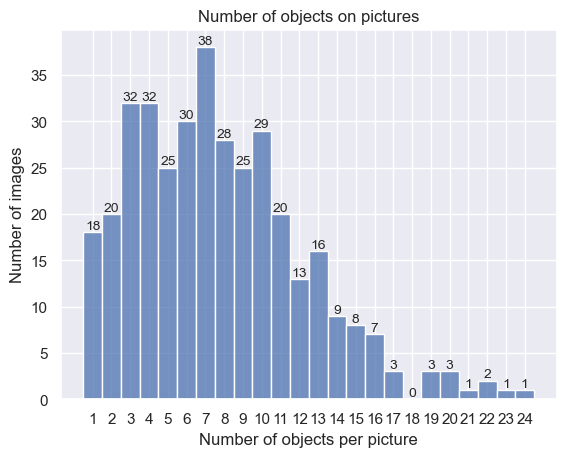

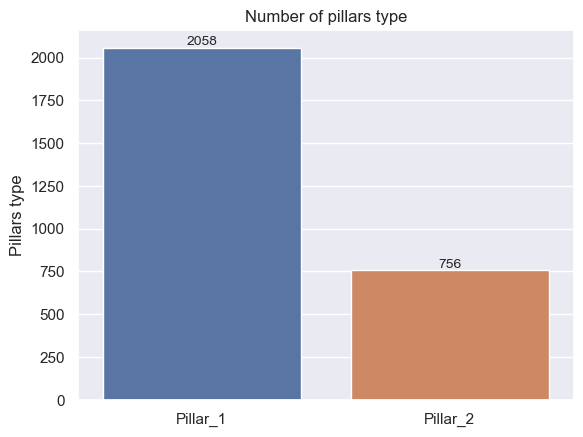

In [4]:
annotations_files = [file for file in sorted(os.listdir(os.path.join('./Dataset', "annotations"))) if not file=='classes.txt']

max_lines = 0
#two_corner_files = []
#three_corners_files = []
objects_on_images = []
pillars = {'Pillar_1': 0, 'Pillar_2': 0}
for file in annotations_files: 
    with open(os.path.join('./Dataset', "annotations/") + file, 'r') as f:
        lines = f.readlines()
        objects = 0
        corners = 0
        pillar_1 = 0
        pillar_2 = 0
        for num, line in enumerate(lines):
            if int(line.split()[0]) in (0, 1):
                objects += 1
            if int(line.split()[0]) == 0:
                pillars['Pillar_1'] += 1
                pillar_1 += 1
            elif int(line.split()[0]) == 1:
                pillars['Pillar_2'] += 1
                pillar_2 += 1 
            else:
                corners += 1
        objects_on_images.append(objects)
        if (pillar_1 * 2) + (pillar_2 * 3) != corners:
            print(f'Wrong assignment in {file}')

import seaborn as sns

sns.set_theme()

objects_per_image_hist = sns.histplot(objects_on_images, discrete=True)
objects_per_image_hist.set_title('Number of objects on pictures')
objects_per_image_hist.set_xlabel('Number of objects per picture')
objects_per_image_hist.set_ylabel('Number of images')
objects_per_image_hist.set(xticks=np.arange(1,25,1))
for container in objects_per_image_hist.containers:
    objects_per_image_hist.bar_label(container, fontsize=10)
plt.show()

two_pillars = sns.barplot(x=list(pillars.keys()), y=list(pillars.values()))
two_pillars.bar_label(two_pillars.containers[0], fontsize=10)
two_pillars.set_title('Number of pillars type')
two_pillars.set_ylabel('Pillars type')
plt.show()

In [5]:
class PillarsDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
        self.annotations_files = [file for file in self.annotations_files if not file=='classes.txt']
        #with open(os.path.join(root, "annotations", 'classes.txt'), 'r') as f:
            #self.classes = f.readlines()
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_h, img_w = img_original.shape[0], img_original.shape[1]
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        #print(type(img_original))
        
        with open(annotations_path) as f:
            lines = f.readlines()
        
        bboxes_original = []
        bboxes_labels_original = []
        for line in lines:
            line = line.strip().split()
            if int(line[0]) in (0, 1):
                x_c, y_c = round(float(line[1]) * img_w), round(float(line[2]) * img_h)
                width, height = round(float(line[3]) * img_w), round(float(line[4]) * img_h)
                x1, y1, x2, y2 = (2*x_c - width)/2, (2*y_c - height)/2, (2*x_c + width)/2, (2*y_c + height)/2
                bboxes_original.append([x1, y1, x2, y2])
                bboxes_labels_original.append(classes[int(line[0]) + 1])
        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            #keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            #                              [[x, y] for sublist in lst for item in sublist for x, y,_ in item]
#            print(keypoints_original, '\n', keypoints_original_flattened)
            # Apply augmentations
           # keypoints_original_flattened = (np.array(keypoints_original_flattened) * [img_w, img_h]).astype(np.int32).tolist()
           # bboxes_original_t = (np.array(bboxes_original) * [[img_w, img_h, img_w, img_h]]).astype(np.int32).tolist()
#            print(bboxes_original_t)
            try:
                transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original)
            except Exception as e:
                print(f'Lines was:\n{lines}\n\n\nImage width and height: {img_w}, {img_h}\n\n\nImage path: {img_path}')
                raise e
            img = transformed['image']
#            print(img.shape)
            bboxes = transformed['bboxes']
           # bboxes = (np.array(bboxes) / [[img.shape[0], img.shape[1], img.shape[0], img.shape[1]]]).tolist()
           # print(bboxes)
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()
            #keypoints_transformed_unflattened = [[]]
            #for kp in transformed['keypoints']:
            #    keypoints_transformed_unflattened[0].append(list(kp))
#            print(transformed['keypoints'], '\n', keypoints_transformed_unflattened)
            
            #print(keypoints_transformed_unflattened)
           # keypoints_transformed_unflattened = (np.array(keypoints_transformed_unflattened) / [[img.shape[0], img.shape[1]]]).tolist()
#            print(keypoints_transformed_unflattened)
           
            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            #keypoints = []
            #for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
            #    obj_keypoints = []
            #    for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
#                    print([keypoints_original[o_idx][k_idx][2]], kp)
            #        obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
            #    keypoints.append(obj_keypoints)
            #print(keypoints)
        else:
            try:
                img, bboxes = img_original, bboxes_original        
            except Exception as e:
                print(img_path)
                raise e
        # Convert everything into a torch tensor
        #print(bboxes)
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([inv_classes[v] for v in bboxes_labels_original], dtype=torch.int64) # all objects are buildings
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])#[(bbox[3] - bbox[1]) * (bbox[2] - bbox[0]) for bbox in bboxes]
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
#        print(keypoints)
        #target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([inv_classes[v] for v in bboxes_labels_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])#[(bbox[3] - bbox[1]) * (bbox[2] - bbox[0]) for bbox in bboxes_original]
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        #target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

In [6]:
KEYPOINTS_FOLDER_TRAIN = './Dataset'
KEYPOINTS_FOLDER_EVAL = './Dataset'

images = [image[:-4] for image in os.listdir(os.path.join(KEYPOINTS_FOLDER_TRAIN, 'images'))]
annotations = [ann[:-4] for ann in os.listdir(os.path.join(KEYPOINTS_FOLDER_TRAIN, 'annotations'))]
extra_annotations = []
print('Extra annotations:\n')
for ann in annotations:
    if ann not in images:
        print(ann, '\n')
        #extra_annotations.append(ann)
print('\n\nExtra images:\n')

for image in images:
    if image not in annotations:
        print(image, '\n')

        
print(len(images), len(annotations))

Extra annotations:

classes 



Extra images:

364 365


In [7]:
def draw_keypoints(image, keypoints, name):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_title(name)
    image = image.numpy()
    maxValue = image.max()
    image = image*255/maxValue
    image = np.uint8(image).transpose((1, 2, 0))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    radius = 2 + 2*int(image.shape[0] > 700) + 2*int(image.shape[1] > 700)

#    cv2.imwrite('test.jpg', image)
    colors = {1: (0, 0, 255), 0: (255, 0, 0)}
    for kps in keypoints:
        for kp in kps:
            x, y = int(torch.FloatTensor.item(kp[0])), int(torch.FloatTensor.item(kp[1]))
            image = cv2.circle(image, (x,y), radius=radius, color=colors[int(kp[2])], thickness=-1)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [61]:
def train_transform():
    return A.Compose([
        A.OneOf([
        A.Sequential([
            A.RandomRotate90(p=0.5), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True, always_apply=False, p=0.5), # Random change of brightness & contrast
            #A.ToGray(p=1),
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.5, 0.5), p=1),
            A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5)
            ]),
        A.Sequential([
            A.RandomScale(scale_limit=0.1, interpolation=1, always_apply=False, p=0.5)
        ]),
        A.Sequential([
            A.RandomSizedBBoxSafeCrop(500, 500, p=0.5),
        ]),
    ], p=1.0)
    ],
    #keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def eval_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            #A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.5), contrast_limit=(-0.2, 0.2), brightness_by_max=True, always_apply=False, p=1.0), # Random change of brightness & contrast
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.5, 0.5), p=1)
        ], p=1)
    ],
    #keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def test_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.0), contrast_limit=0.0, brightness_by_max=True, always_apply=False, p=1.0), # Random change of brightness & contrast
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.1, 0.9), p=1)
        ], p=1)
    ])

In [20]:
def visualize(image, bboxes, labels, image_original=None, bboxes_original=None, label=None):
    import seaborn as sns
    fontsize = 18
    sns.set_style("white")
    color = {1: (255, 0, 0), 2: (0, 255, 0)}
    thickness = max(int(max(image.shape) * 0.001), 1)
    for bbox, pillar in zip(bboxes, labels):
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, color[pillar], thickness)
    
    #radius = 2 + 2*int(image.copy().shape[0] > 700) + 2*int(image.copy().shape[1] > 700)
#    cv2.imwrite('test.jpg', image)
    #colors = {0: (0, 0, 255), 1: (255, 0, 0)}
    
    if label:    
        cv2.imwrite(f'./Visualize/{label}_test.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    if image_original is None:
        plt.figure(figsize=(15,15))
        plt.imshow(image)
    else:
        for bbox, pillar in zip(bboxes_original, labels):
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, color[pillar], 5)

        f, ax = plt.subplots(1, 2, figsize=(20, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        #cv2.imwrite(f'./Visualize/{label}_test.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        

ZON_1_00785_rod.txt


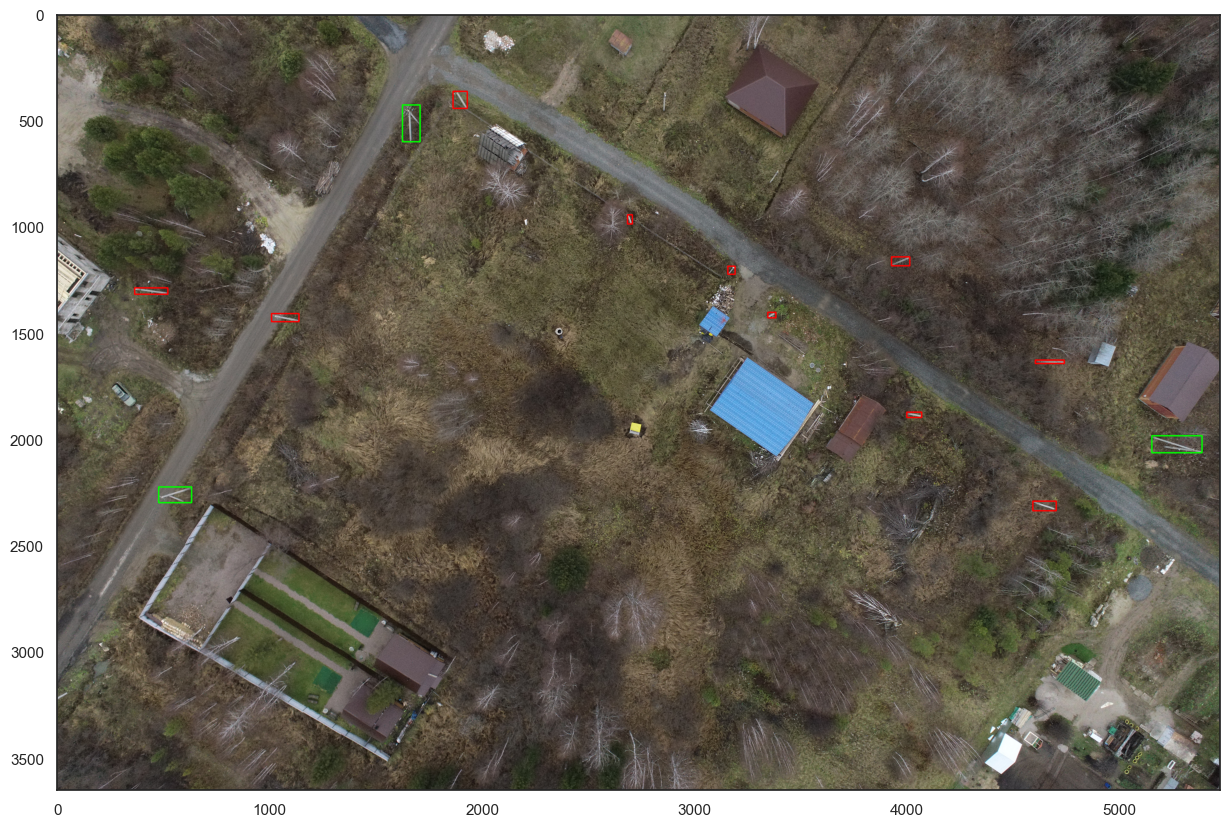

In [10]:
KEYPOINTS_FOLDER = './Dataset'

dataset = PillarsDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)



data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()
labels = batch[1][0]['labels'].detach().cpu().numpy().astype(np.int32).tolist()
#print(bboxes)
#bboxes = (bboxes * [[image.shape[1], image.shape[0], image.shape[1], image.shape[0]]]).astype(np.int32).tolist()
#print(bboxes)
#print(bboxes)

idx = torch.IntTensor.item(batch[1][0]['image_id'])
#print(idx)
print(dataset.annotations_files[idx])

#keypoints = []
#print(batch[1][0]['keypoints'].detach().cpu().numpy())
#for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#    t = np.array([kp * [image.shape[0], image.shape[1], 1.0] for kp in kps]).astype(np.int32).tolist()
#    keypoints.append(t)
#    keypoints.append([kp for kp in kps])


#keypoints = keypoints.numpy().astype(np.int32).tolist()

#print(keypoints)
#image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
#bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

#keypoints_original = []
#for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#    keypoints_original.append([kp for kp in kps])
#print(len(dataset))
visualize(image, bboxes, labels, label='test')

#print(image)
#print(keypoints)

ZON_1_01070_rod.txt


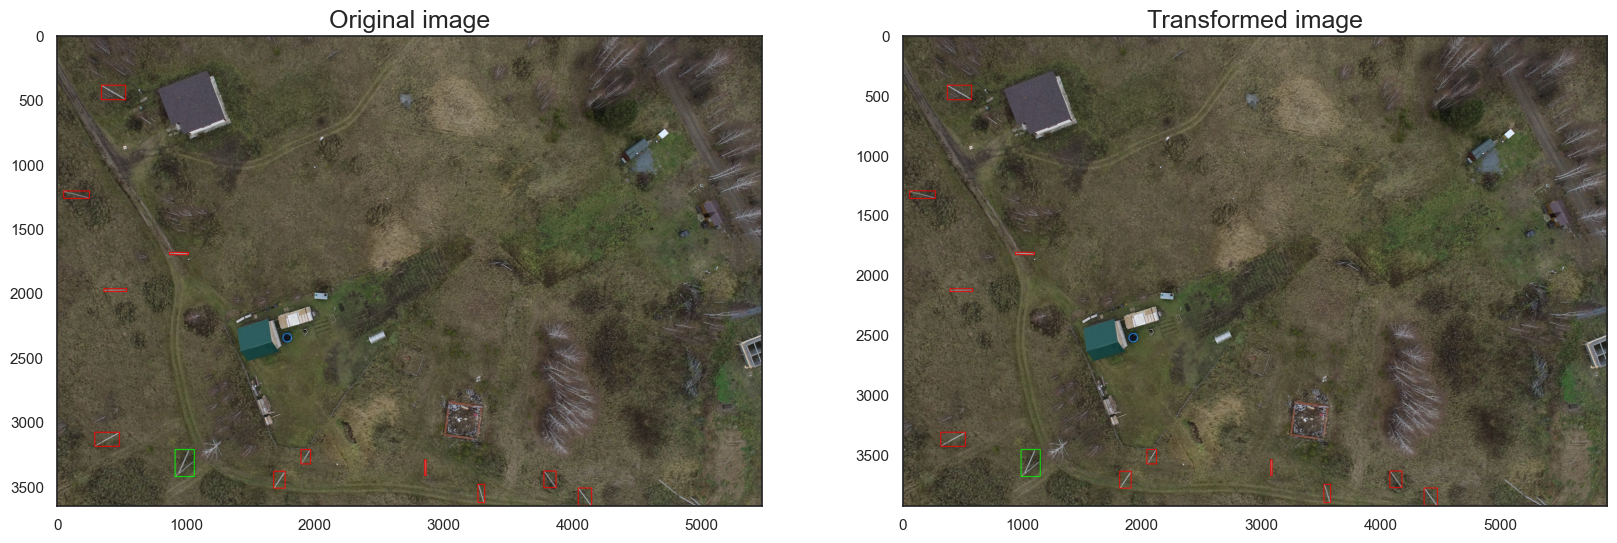

In [62]:
KEYPOINTS_FOLDER_TRAIN = './Dataset'
dataset = PillarsDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
#print(image.shape)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()
labels = batch[1][0]['labels'].detach().cpu().numpy().astype(np.int32).tolist()
#bboxes = (bboxes * [[image.shape[0], image.shape[1], image.shape[0], image.shape[1]]]).astype(np.int32).tolist()
#print(bboxes)
idx = torch.IntTensor.item(batch[1][0]['image_id'])
#print(idx)
print(dataset.annotations_files[idx])

#keypoints = []
#print(batch[1][0]['keypoints'].detach().cpu().numpy())
#for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#    t = np.array([kp * [image.shape[0], image.shape[1], 1.0] for kp in kps]).astype(np.int32).tolist()
#    keypoints.append(t)
#    keypoints.append([kp for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()
#bboxes_original = (bboxes_original * [[image_original.shape[1], image_original.shape[0], image_original.shape[1], image_original.shape[0]]]).astype(np.int32).tolist()

#keypoints_original = []
#for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#    keypoints_original.append([kp for kp in kps])
#    t = np.array([kp * [image_original.shape[1], image_original.shape[0], 1.0] for kp in kps]).astype(np.int32).tolist()
#    keypoints_original.append(t)
    
#print(keypoints)
#print(len(dataset))
visualize(image, bboxes, labels, image_original, bboxes_original)

In [25]:
def get_pillar_detection_model(num_classes, pretrain=True, weights_path=None):
    from torch import nn
    import torchvision
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    from torchvision.models.detection.rpn import AnchorGenerator
    # load a model pre-trained pre-trained on COCO
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0))
    
    if pretrain:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT', min_size=1500, max_size=5000, class_weigth=[1.0, 3.0])
    else:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1) # lenght of classes WITHOUT background on input
    
    #model.rpn.anchor_generator = anchor_generator
    
#    model.roi_heads.box_predictor.cls_score = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 2))
    
#    model.roi_heads.box_predictor.bbox_pred = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 8))
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [26]:
model = get_pillar_detection_model(num_classes=5)

#print(model)

In [17]:
#model_path = 'C:/Users/User/Petr/Net_1/Source/save_model/model_weights_fourth_Alb_0.38.pth'
#classes = {'Building': 1}
#path = 'C:/Users/User/Petr/temp_images'

#model_d = load_model(model_path)

#backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features

In [27]:
def plot_stats(num_epochs, bbox_stats, loss_bb, loss_cls, loss, num=None):
    import seaborn as sns
    import pandas as pd
    
    sns.set_theme()
    sns.set_style("darkgrid")
    
#    stats = pd.DataFrame({
#        'Epoch': range(num_epochs),
#        'Bbox_stat': bbox_stats,
#        'Kps_stat': kps_stats})
    
    if num_epochs // 10 >= 5:
        step = 10
    else:
        step = 1
    
    stats_bb = pd.DataFrame(data=bbox_stats[::step], columns=['IoU=0.50:0.95 | area = all', 'IoU=0.50         | area = all', 'IoU=0.75         | area = all', 'IoU=0.50:0.95 | area = small', 'IoU=0.50:0.95 | area = medium', 'IoU=0.50:0.95 | area = large'])
    stats_bb['Epoch'] = range(num_epochs)[::step]
    stats_bb_melt = pd.melt(stats_bb, id_vars=['Epoch'])
    
    #stats_kp = pd.DataFrame(data=kps_stats[::step], columns=['IoU=0.50:0.95 | area = all', 'IoU=0.50         | area = all', 'IoU=0.75         | area = all', 'IoU=0.50:0.95 | area = small', 'IoU=0.50:0.95 | area = medium', 'IoU=0.50:0.95 | area = large'])
    #stats_kp['Epoch'] = range(num_epochs)[::step]
    #stats_kp_melt = pd.melt(stats_kp, id_vars=['Epoch'])
    
#    print(bbox_stats)
#    print(kps_stats)
#    print([loss_bb, loss_kp])
    losses = pd.DataFrame()
    losses['Epoch'] = range(num_epochs)[::step]
    losses['Bounding Box loss'] = loss_bb[::step]
    #losses['Keypoints loss'] = loss_kp[::step]
    losses['Classifier'] = loss_cls[::step]
    losses['Loss general'] = loss[::step]
    losses_melt = pd.melt(losses, id_vars=['Epoch'])

#    stats_melt = pd.melt(stats, id_vars=['Epoch'])

    figure, axes = plt.subplots(2, 1, figsize=(40, 40))
#    print(axes)

    figure.suptitle('Metrics', fontsize=22)
    first = sns.pointplot(data=stats_bb_melt, x='Epoch', y='value', hue='variable', ax=axes[0])#, style='variable', markers=True, dashes=False
#    first.set(xticks=np.arange(0,num_epochs,1))
#NPoints_hist.bar_label(NPoints_hist.containers[0], fontsize=10)
    axes[0].xaxis.grid(True)
    axes[0].set_ylim(ymin=-0.01)
    axes[0].legend(loc='upper left', fontsize='x-large')
    axes[0].set_title('Average Precision of Bounding boxes', fontsize=18)
    axes[0].set_xlabel('Epoch\n\n\n', fontsize=18)
    axes[0].set_ylabel('Metrics values', fontsize=18)

    #second = sns.pointplot(data=stats_kp_melt, x='Epoch', y='value', hue='variable', ax=axes[1])
#    second.set(xticks=np.arange(0,num_epochs,1))
    #axes[1].xaxis.grid(True)
    #axes[1].set_ylim(ymin=-0.01)
    #axes[1].legend(loc='upper left', fontsize='x-large')
    #axes[1].set_title('Average Precision of Keypoints', fontsize=18)
    #axes[1].set_xlabel('Epoch', fontsize=18)
    #axes[1].set_ylabel('Metric values', fontsize=18)
    
    third = sns.pointplot(data=losses_melt, x='Epoch', y='value', hue='variable', ax=axes[1])
#    second.set(xticks=np.arange(0,num_epochs,1))
    axes[1].xaxis.grid(True)
#    axes[2].set_ylim(ymin=-0.01)
    axes[1].legend(loc='upper left', fontsize='x-large')
    axes[1].set_title('Losses', fontsize=18)
    axes[1].set_xlabel('Epoch', fontsize=18)
    axes[1].set_ylabel('Loss values', fontsize=18)
    
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.show()
    
    if num:
        figure.savefig(f'./Metric_log/Metric_log_{num + 1}a.jpg')
    else:
        figure.savefig(f'./Metric_log/Metric_log.jpg')
        #print('Figure saved')
    
#plot_stats(num_epochs=10, bbox_stats=bbox_stats, kps_stats=kps_stats, loss_bb=loss_bb, loss_kp=loss_kp, loss=loss)

Epoch: [0]  [  0/146]  eta: 0:44:52  lr: 0.000001  loss: 0.5316 (0.5316)  loss_classifier: 0.2086 (0.2086)  loss_box_reg: 0.2660 (0.2660)  loss_objectness: 0.0266 (0.0266)  loss_rpn_box_reg: 0.0304 (0.0304)  time: 18.4430  data: 2.3229  max mem: 12072
Epoch: [0]  [ 10/146]  eta: 0:27:30  lr: 0.000008  loss: 0.4079 (0.4307)  loss_classifier: 0.1731 (0.1851)  loss_box_reg: 0.1898 (0.1839)  loss_objectness: 0.0264 (0.0319)  loss_rpn_box_reg: 0.0304 (0.0298)  time: 12.1396  data: 1.7421  max mem: 12216
Epoch: [0]  [ 20/146]  eta: 0:24:36  lr: 0.000015  loss: 0.4079 (0.4649)  loss_classifier: 0.1731 (0.1909)  loss_box_reg: 0.1969 (0.2121)  loss_objectness: 0.0241 (0.0289)  loss_rpn_box_reg: 0.0269 (0.0331)  time: 11.3848  data: 1.8415  max mem: 12226
Epoch: [0]  [ 30/146]  eta: 0:22:29  lr: 0.000021  loss: 0.4390 (0.4707)  loss_classifier: 0.1776 (0.1936)  loss_box_reg: 0.2076 (0.2150)  loss_objectness: 0.0259 (0.0283)  loss_rpn_box_reg: 0.0269 (0.0338)  time: 11.3609  data: 2.0095  max mem

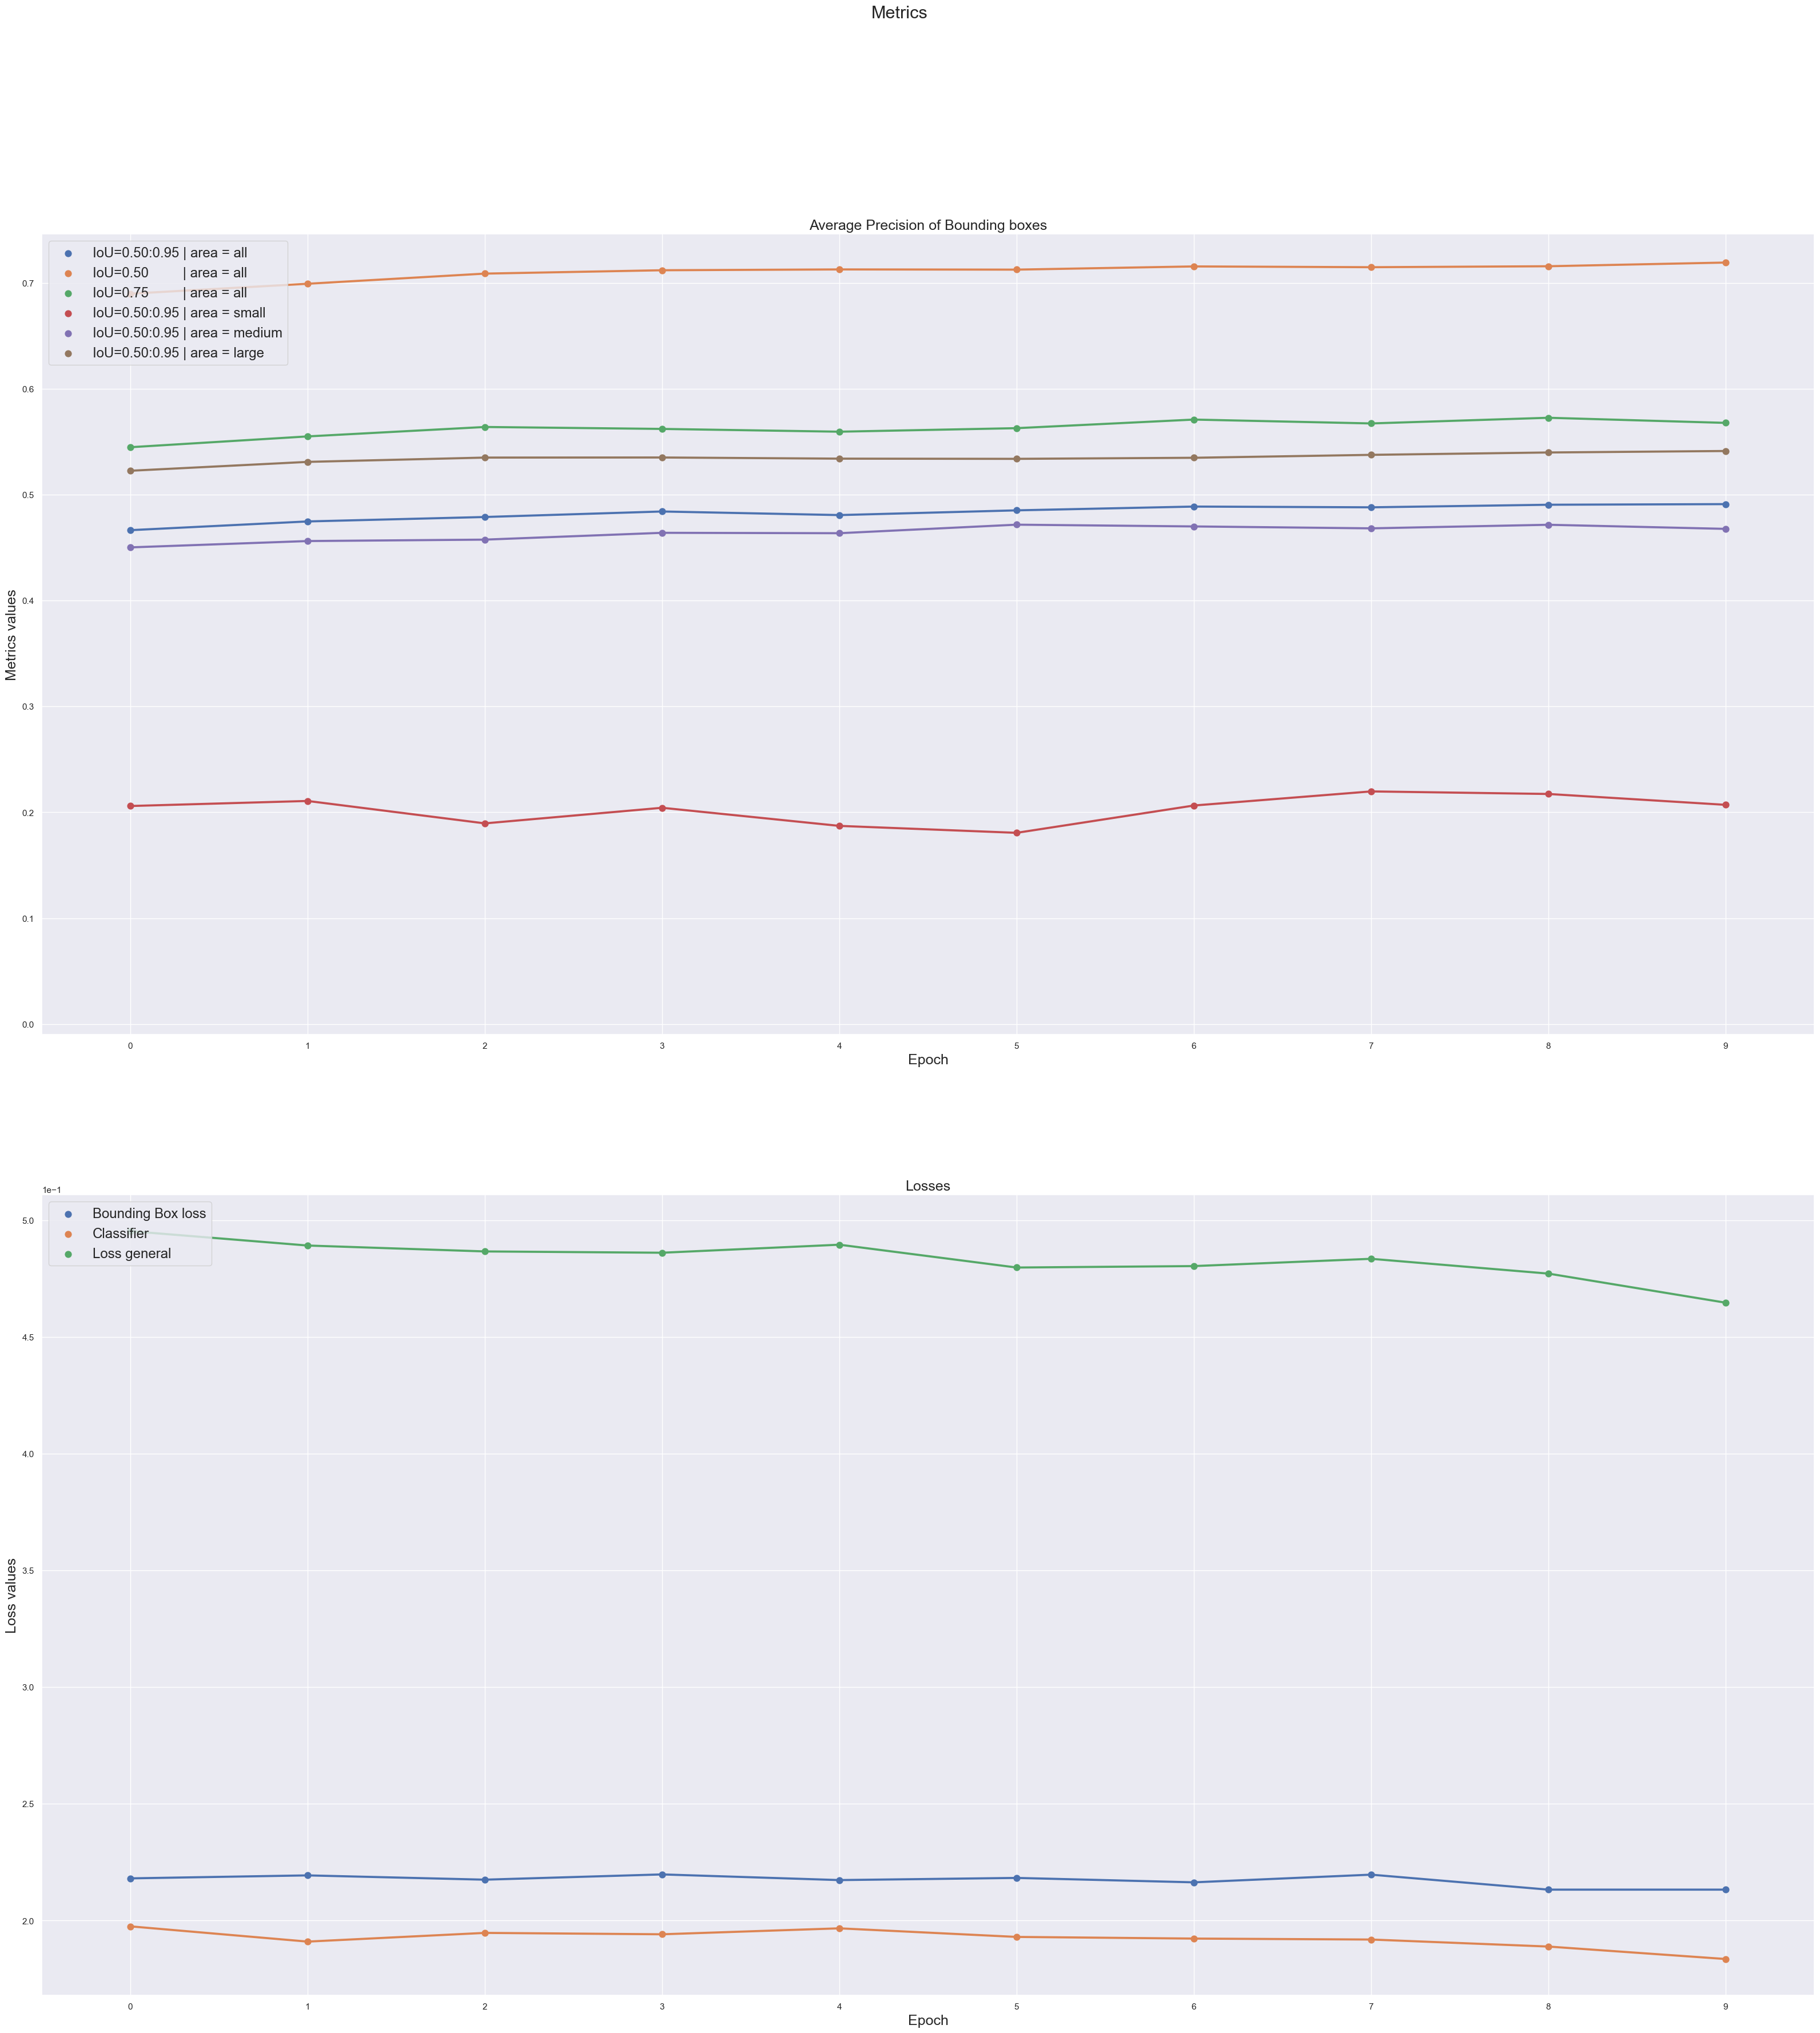

In [63]:
for num in range(1):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
    
    KEYPOINTS_FOLDER_TRAIN = './Dataset'
    KEYPOINTS_FOLDER_EVAL = './Dataset'

    dataset_train = PillarsDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
    dataset_test = PillarsDataset(KEYPOINTS_FOLDER_EVAL, transform=eval_transform(), demo=False)

    indices = torch.randperm(len(dataset_train)).tolist()
    thirty_pc = int(len(dataset_train) * 0.20)
    dataset_train = torch.utils.data.Subset(dataset_train, indices[:-thirty_pc])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-thirty_pc:])




    data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
    data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = get_pillar_detection_model(num_classes=2,
                                      weights_path='./save_model/weights_6.pth')#, weights_path='./save_model/weights_rebuild_model_2.pth'


    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    #params1 = [p for p in model.roi_heads.keypoint_head.parameters() if p.requires_grad]
    
    optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.90)#, weight_decay=0.0001
    
    #optimizer = torch.optim.SGD([{'params': params1},
    #                             {'params': model.roi_heads.keypoint_predictor.parameters(), 'lr': .001},], lr=0.001, momentum=0.90)#, weight_decay=0.0001
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)
    num_epochs = 10

    #kps_stats = []
    bbox_stats = []

    loss_bb = []
    loss_cls = []
    #loss_kp = []
    loss = []

    for epoch in range(num_epochs):
        logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
        lr_scheduler.step()
        evaluator = evaluate(model, data_loader_test, device)
        
        #kps_stats.append(evaluator.coco_eval['keypoints'].stats[:6])
        
        #TODO: Change lr_scheduler step and gamma after Nth epoch
        
        bbox_stats.append(evaluator.coco_eval['bbox'].stats[:6])
    
        loss_bb.append(logger.meters['loss_box_reg'].global_avg)
        loss_cls.append(logger.meters['loss_classifier'].global_avg)
        #loss_kp.append(logger.meters['loss_keypoint'].global_avg)
        loss.append(logger.meters['loss'].global_avg)

    plot_stats(num_epochs, bbox_stats, loss_bb, loss_cls, loss)#, num=num
#print(type(meters[0]['loss_keypoint']))

# Save model weights after training
#torch.save(model.state_dict(), './save_model/weights_2.pth')
    torch.save(model.state_dict(), './save_model/weights_6.pth')

In [ ]:
def cut_score(predictions: dict, score_thresh = 0.5):
    cut_index = None
    for indx, score in enumerate(predictions['scores']):
        if score < score_thresh:
            cut_index = indx
            break
    if not cut_index:
        cut_index = len(predictions['scores']) - 1
    new_pred = {}

    new_pred['boxes'] = pred['boxes'][:cut_index]
    new_pred['labels'] = pred['labels'][:cut_index]
    new_pred['scores'] = pred['scores'][:cut_index]

    return new_pred

In [32]:
torch.save(model.state_dict(), './save_model/weights_6.pth')

In [64]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks, save_image

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#model = get_pillar_detection_model(num_classes=2, weights_path='./save_model/weights_6.pth')

#model.to(device)

im_path_test = 'C:/Users/User/Petr/Net_3/test_model/images/'
color = {1: (255, 0, 0), 2: (0, 255, 0)}
#print(os.listdir(im_path_test))
for im in os.listdir(im_path_test):
    image = cv2.imread(im_path_test + im)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    eval_transforms = eval_transform()

    model.eval()
    with torch.no_grad():
        #x = eval_transforms(image=image)
        #x = x['image']
        x = F.to_tensor(image)
    #sample = self.transforms(image=image,
    #                                 bboxes=boxes,
    #                                 class_labels=labels,
    #                                 cropping_bbox=cropping_bbox)
    # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
    #x = x.to(device)
        predictions = model([x, ])
        pred = predictions[0]
        #pred = cut_score(predictions=pred, score_thresh=0.5)
    #print(pred)
    image = torch.from_numpy(image)
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    
    scores = pred['scores'].detach().cpu().numpy()
    high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
    post_nms_idxs = torchvision.ops.nms(pred['boxes'][high_scores_idxs], pred['scores'][high_scores_idxs], 0.3).cpu().numpy()
    bboxes = []
    #print(pred['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy())
    for bbox in pred['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        #print(bbox)
        bboxes.append(list(map(int, bbox.tolist())))
        #bboxes.append(bbox)
    
    bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
    #print(bboxes)
    labels = []
    for label in pred['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        labels.append(label)
        
    scores_clear = []
    for score in pred['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        scores_clear.append(score)
#print(image.shape, image.dtype)
#image = image[:3, ...]
#print(image.shape, image.dtype)
    pred_labels = [f"{classes[label]}: {score:.3f}" for label, score in zip(labels, scores_clear)]
    #pred_boxes = pred["boxes"].long()
    colors = [color[label] for label in labels]
    print(labels)
    if len(bboxes) > 0:
        output_image = draw_bounding_boxes(image=image.permute(2, 0, 1), boxes=bboxes, colors=colors, width=5, font_size=50, font='./TimesNewRomanRegular.ttf')#labels=pred_labels,   
    else:
        output_image = image.permute(2, 0, 1)
    save_image(output_image / 255, './test_model/pred/' + im[:-4] + '_pred.jpg')


[]
[1, 1, 1]
[1, 1]
[1, 1, 1, 2]
[1, 1, 1, 2, 1, 1, 1]
[1]
[2, 1, 1, 1, 1, 1]


In [ ]:
import os
path = './Dataset/temp/'
for image in os.listdir(path):
    os.rename(path + image, path + image[:-4] + '_rod' + image[-4:])

In [ ]:
# Save model weights after training
torch.save(model.state_dict(), './save_model/weights_rebuild_model_summer.pth')

In [ ]:
KEYPOINTS_FOLDER = './'
dataset_test = ClassDataset(KEYPOINTS_FOLDER, transform=None, demo=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_keypoints = 17, weights_path='./save_model/weights.pth')
model.to(device);

In [ ]:
data_loader_test_1 = DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=collate_fn)
iterator = iter(data_loader_test_1)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

#print("Predictions: \n", output)

In [ ]:
image = cv2.imread('./check_model/temp3.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = F.to_tensor(img)
img = img.to(device)
images = [img]
with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)
    
#print(output)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_V2(num_keypoints = 9, weights_path='./save_model/weights_new_dataset.pth')
model.to(device);
#print(model)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

path = 'C:/Users/User/Desktop/Teobox_Shipunovo_2022-10-16T21.03.14/export_shapes_2/shape_556/'
path_E = './check_model/images'

images = []



for num, label in enumerate(os.listdir(path_E)):
    #print(os.path.join(path_E, label))
    #if num >= 15:
    #    break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path_E, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)
    img = img.to(device)
    images.append((img, label))

images_t = []
for num, label in enumerate(os.listdir(path_E)):
    #if num >= 15:
    #    break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path_E, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = F.to_tensor(img)
    #img = img.to(device)
    images_t.append((img, label))
#print(type(images[0][0]))
images_transformed = []
for pair in images_t:
    #img = A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1)(image=pair[0])['image']
    #img = A.InvertImg(p=1)(image=img)['image']
    #img = A.Sharpen(alpha=(0.1, 0.9), p=1)(image=img)['image']
    img = test_transform()(image=pair[0])['image']
    img = F.to_tensor(img)
    img = img.to(device)
    images_transformed.append(img)
with torch.no_grad():
    model.to(device)
    model.eval()
    images_to_pred = images_transformed
    output = model(images_to_pred)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_V2(num_keypoints = 9, weights_path='./save_model/weights_rebuild_model_3.pth')
model.to(device);
#print(model)

In [ ]:
path = 'C:/Users/User/Desktop/Teobox_Shipunovo_2022-10-16T21.03.14/export_shapes/shape_401/'
path_E = 'C:/Users/User/Petr/Net_2/test_dataset/two_dataset/eval/images'

images = []



for num, label in enumerate(os.listdir(path)):
    if num >= 15:
        break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)
    img = img.to(device)
    images.append((img, label))
#print(images)
with torch.no_grad():
    model.to(device)
    model.eval()
    images_to_pred = [image for (image, label) in images]
    output = model(images_to_pred)

In [ ]:
def get_object_detection_model(num_classes):
    from torch import nn
    import torchvision
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.rpn import AnchorGenerator
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # lenght of classes WITHOUT background on input
    
#    model.roi_heads.box_predictor.cls_score = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 2))
    
#    model.roi_heads.box_predictor.bbox_pred = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 8))

    return model


def load_model(filepath: str):   
    model = get_object_detection_model(num_classes=2)
    model.load_state_dict(torch.load(filepath))
    return model



In [ ]:
for image, out in zip(images, output):
    label = image[1][:-4] + 'big_ds'
    image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    scores = out['scores'].detach().cpu().numpy()


    high_scores_idxs = np.where(scores > 0.75)[0].tolist() # Indexes of boxes with scores > 0.7
    post_nms_idxs = torchvision.ops.nms(out['boxes'][high_scores_idxs], out['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes
#    print(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0])
    if not len(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
        good_kps_idxs = [[]]
    else:
        good_kps_idxs = np.where(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0] > 0.0) # for i in range(len(post_nms_idxs))
#    print(good_kps_idxs[0])
#    print('KPs: ', out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0][good_kps_idxs[0]])
    #kps_scores_filtered = out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0][good_kps_idxs[0]]
#print(kps_scores_filtered)

#kps_filtered =  output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
#out['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
#print(kps_filtered)

    keypoints = []
    for kps in out['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        keypoints.append([list(map(int, kp)) for kp in kps[good_kps_idxs[0]]])
#kps_idxs = np.where(output[0]['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0] > 1.2)[0]
#print(kps_idxs)
#print(np.array(keypoints)[0][kps_idxs])
#keypoints = [np.array(keypoints)[0][kps_idxs].tolist()]
    print(keypoints)
#keypoints = average_close_points(keypoints)
#print(keypoints)
    
    bboxes = []
    for bbox in out['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        bboxes.append(list(map(int, bbox.tolist())))
    

    
    visualize(image, bboxes, keypoints)

In [ ]:
import shutil

for file in two_corner_files:
    #shutil.copy(f'./test_dataset/train/images/{file}.jpg', f'./test_dataset/two_dataset/train/images/{file}.jpg')
    #shutil.copy(f'./test_dataset/train/annotations/{file}.txt', f'./test_dataset/two_dataset/train/annotations/{file}.txt')
    
    shutil.copy(f'./test_dataset/eval/images/{file}.jpg', f'./test_dataset/two_dataset/eval/images/{file}.jpg')
    shutil.copy(f'./test_dataset/eval/annotations/{file}.txt', f'./test_dataset/two_dataset/eval/annotations/{file}.txt')
    
for file in three_corners_files:
    #shutil.copy(f'./test_dataset/train/images/{file}.jpg', f'./test_dataset/three_dataset/train/images/{file}.jpg')
    #shutil.copy(f'./test_dataset/train/annotations/{file}.txt', f'./test_dataset/three_dataset/train/annotations/{file}.txt')
    
    shutil.copy(f'./test_dataset/eval/images/{file}.jpg', f'./test_dataset/three_dataset/eval/images/{file}.jpg')
    shutil.copy(f'./test_dataset/eval/annotations/{file}.txt', f'./test_dataset/three_dataset/eval/annotations/{file}.txt')

In [ ]:
import shutil

for file in os.listdir('./annotations/'):
    if file[:-4] not in extra_annotations:
        shutil.copy(f'./annotations/{file}', f'./annotations_clear/{file}')

In [ ]:
#import numpy as np

def average_close_points(point_coords): 
    #point_coords = np.array([point[:-1] for point in point_coords[0]])
    point_coords = np.array(point_coords[0])
    maping = np.abs(point_coords[:, None, None] - point_coords[None, :, None]) <= 3
    print(maping)
    maping = maping.reshape(maping.shape[0], maping.shape[1], 3)
    print(maping)
    res = []
    for point in maping:
        res.append(np.average(point_coords, axis=0, weights=point))
    #point_coords = np.average(point_coords, axis=0, weights=maping)
    
    return [np.unique(res, axis=0).astype(int)]

In [ ]:
average_close_points(keypoints)

In [ ]:
from torchview import draw_graph

model_v = get_model(num_keypoints=4)

model_graph = draw_graph(model_v, input_size=(1, 3, 128, 128))
model_graph.visual_graph

In [ ]:
from torch import nn
from torch.nn import functional as Fnn

class MyModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,kernel_size=(2,2),stride=1,padding='valid')
        self.conv1_1 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(2,2),stride=1,padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(2,2),stride=1,padding='valid')
        self.conv2_2 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(2,2),stride=1,padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.dropout1 = nn.Dropout(0.5)
        self.linear1 = nn.Linear(in_features=32*149*149,out_features=500)
        self.linear2 = nn.Linear(in_features=500,out_features=250)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(in_features=250,out_features=18)


    def forward(self,x):
        #x = cv2.resize(x, (600, 600))
        x = Fnn.relu(self.conv1(x))
        x = Fnn.relu(self.conv1_1(x))
        x = self.maxpool1(x)
        x = Fnn.relu(self.conv2(x))
        x = Fnn.relu(self.conv2_2(x))
        x = self.maxpool2(x)
        #print(x.shape)
        x = x.view(-1,32*149*149) 
        x = self.dropout1(x)
        x = Fnn.relu(self.linear1(x))
        x = Fnn.relu(self.linear2(x))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x


In [ ]:
model_self = MyModel()

criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
#device = torch.device('cuda')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_self.to(device)
# Training loop
num_epochs = 5

KEYPOINTS_FOLDER_TRAIN = './NEW_DATASET'
KEYPOINTS_FOLDER_EVAL = './NEW_DATASET'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_EVAL, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader_train):
         # [[[x, y, v], [x, y, v], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0]]]
        points = [point for point in labels[0]['keypoints'][0]]
        kps = []
        for point in points:
            x, y, v = point
            kps.append([(x-600)/600, (y-600)/600])
        #kps = [(x, y) for point in points for x, y, v in point]
        #kps.reshape(1, 8)
        #print(kps)
        #print(images[0].numpy())
        images = cv2.resize(images[0].numpy().transpose(1,2,0), (600, 600))
        #print(images)
        images = F.to_tensor(images).cuda()
        labels = torch.as_tensor(kps).cuda()
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_self(images).to(device)
        #print(outputs)
        labels = labels.view(-1, 18)
        #print(labels)
        loss = torch.sqrt(criterion(outputs, labels))
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Print Epoch, Step and Loss value.
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(data_loader_train), loss.item()))

In [ ]:
import re
def has_cyrillic(text):
    return bool(re.search('[а-яА-Я]', text))

path = 'C:/Users/User/Petr/Net_2/test.jpg'

has_cyrillic(path)

In [ ]:
image = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(image)